https://github.com/nicolov/naive_bayes_tensorflow/blob/master/tf_iris.py

In [0]:
#!/usr/bin/env python3

"""
Flower classification on the Iris dataset using a Naive Bayes
classifier and TensorFlow.
For more info: http://nicolovaligi.com/naive-bayes-tensorflow.html
"""

from IPython import embed
from matplotlib import colors
from matplotlib import pyplot as plt
from sklearn import datasets
import numpy as np
import tensorflow as tf
from sklearn.utils.fixes import logsumexp
import numpy as np


class TFNaiveBayesClassifier:
    dist = None

    def fit(self, X, y):
        # Separate training points by class (nb_classes * nb_samples * nb_features)
        unique_y = np.unique(y)
        points_by_class = np.array([
            [x for x, t in zip(X, y) if t == c]
            for c in unique_y])

        # Estimate mean and variance for each class / feature
        # shape: nb_classes * nb_features
        mean, var = tf.nn.moments(tf.constant(points_by_class), axes=[1])

        # Create a 3x2 univariate normal distribution with the 
        # known mean and variance
        self.dist = tf.distributions.Normal(loc=mean, scale=tf.sqrt(var))

    def predict(self, X):
        assert self.dist is not None
        nb_classes, nb_features = map(int, self.dist.scale.shape)

        # Conditional probabilities log P(x|c) with shape
        # (nb_samples, nb_classes)
        cond_probs = tf.reduce_sum(
            self.dist.log_prob(
                tf.reshape(
                    tf.tile(X, [1, nb_classes]), [-1, nb_classes, nb_features])),
            axis=2)

        # uniform priors
        priors = np.log(np.array([1. / nb_classes] * nb_classes))

        # posterior log probability, log P(c) + log P(x|c)
        joint_likelihood = tf.add(priors, cond_probs)

        # normalize to get (log)-probabilities
        norm_factor = tf.reduce_logsumexp(
            joint_likelihood, axis=1, keep_dims=True)
        log_prob = joint_likelihood - norm_factor
        # exp to get the actual probabilities
        return tf.exp(log_prob)

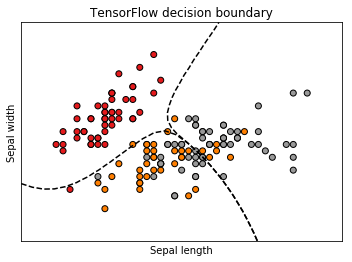

In [4]:
iris = datasets.load_iris()
# Only take the first two features
X = iris.data[:, :2]
y = iris.target

tf_nb = TFNaiveBayesClassifier()
tf_nb.fit(X, y)

# Create a regular grid and classify each point
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))
s = tf.Session()
Z = s.run(tf_nb.predict(np.c_[xx.ravel(), yy.ravel()]))
# Extract probabilities of class 2 and 3
Z1 = Z[:, 1].reshape(xx.shape)
Z2 = Z[:, 2].reshape(xx.shape)

# Plot
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
# Swap signs to make the contour dashed (MPL default)
ax.contour(xx, yy, -Z1, [-0.5], colors='k')
ax.contour(xx, yy, -Z2, [-0.5], colors='k')

ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_title('TensorFlow decision boundary')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
fig.savefig('tf_iris.png', bbox_inches='tight')